In [ ]:
import networkx as nx
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

from relevant_functions import Granover_methods as GM

Random_seed = 42
random.seed(Random_seed)
np.random.seed(Random_seed)


In [2]:
#store nodes and edges data
def load_data(nodes, edges):

    nodes = pd.read_csv(nodes)
    edges = pd.read_csv(
        edges,
        header=None,
        names=["source_new_id", "target_new_id"],
    )
    # merge to get page names
    df_merged = (
        edges
        .merge(nodes[['new_id', 'name']], left_on='source_new_id', right_on='new_id')
        .rename(columns={'name': 'page_name_1'})
        .drop('new_id', axis=1)
        .merge(nodes[['new_id', 'name']], left_on='target_new_id', right_on='new_id')
        .rename(columns={'name': 'page_name_2'})
        .drop('new_id', axis=1)
        .rename(columns={
            'source_new_id': 'page_id_1',
            'target_new_id': 'page_id_2'
        })
    )
    print(nodes.size)
    print(edges.size)
    return df_merged, nodes, edges

In [3]:
#threadpullexecuter
df_merged, nodes, edges = load_data("fb-pages-public-figure.nodes", "fb-pages-public-figure.edges")

34677
134228


In [4]:
def create_facebookpage_network(df):
    """
    Create a network graph from Facebook page data.
    
    Args:
        df (pandas.DataFrame): Facebook page data
        
    Returns:
        networkx.Graph: Undirected graph of Facebook page connections
    """
    print("Creating Facebook page network...")
    
    # Create undirected graph (dataset shows pages in bidirectional connections)
    G = nx.Graph()
    
    # Add edges for each route
    for _, row in df.iterrows():
        source = row['page_name_1']
        dest = row['page_name_2']

        # Skip self-loops
        if source != dest:
            if G.has_edge(source, dest):
                # Increment weight if edge already exists
                G[source][dest]['weight'] += 1
            else:
                # Add new edge with weight 1
                G.add_edge(source, dest, weight=1)

    print(f"Network created with {G.number_of_nodes()} facebook pages and {G.number_of_edges()} connections")

    return G

In [5]:
G = create_facebookpage_network(df_merged)

Creating Facebook page network...
Network created with 11534 facebook pages and 66942 connections


In [ ]:
#define parameters for simulation
#nr of nodes
n = G.number_of_nodes()
#choose treshold distribution as beta because of characteristics 
#of this facebook network, because of its heavy-tailed degree distribution
# and presence of highly connected hubs, which can significantly influence
#the spread of information. The beta distribution allows for flexibility in modeling
#varied adoption thresholds among nodes, capturing the heterogeneity in user behavior
#on social media platforms. This choice helps in realistically simulating how information
#spreads through the network, accounting for both early adopters and more resistant nodes.
treshold_distribution = 'beta'

#seed fractions 0.01 and 0.05 to see difference in spread
# 1% vs 5% will reveal strategy differences
seed_fractions = [0.005,0.01,0.05]

#Because I have a large graph and not a fast laptop I choose 10 repetitions
#per experiment
R = 10

#To save time, choose 100 as max steps, let's see if this is enough for convergence 
max_steps = 100



In [52]:
#compute betweenness approximation to save time
#k = 300 because that gives the best trade-off between accuracy and computation time
# for a graph of this size (11k nodes)
betweenness_approx = nx.betweenness_centrality(G, k=300, seed=42)
#save it so i can use it later
np.save('betweenness_approx_fb.npy', betweenness_approx)


In [41]:
#load precomputed betweenness approximation
betweenness_approx = np.load('betweenness_approx_fb.npy', allow_pickle=True).item()


In [ ]:
#redefine betweenness seeds function to use precomputed betweenness
def betweenness_seeds_precomputed(G, B,betweenness):
     return sorted(betweenness, key=betweenness.get, reverse=True)[:B]

In [ ]:
#draw tresholds for each node in G based on treshold distribution
tresholds = GM.draw_thresholds(G, mode=treshold_distribution, phi_mean=0.3, phi_std=0.1)

In [44]:
#k-core not required and greedy takes too much time
strategies = {
    "Random": lambda B: GM.random_seeds(G, B),
    "Degree": lambda B: GM.high_degree_seeds(G, B),
    "Betweenness": lambda B: betweenness_seeds_precomputed(G, B, betweenness_approx)
}

In [45]:
results = []

In [ ]:

"""
calculates B, the number of initial adopters. for each seeding strategy (Random, Degree, Betweenness) 
run R independent simulations of the threshold dynamics.
each simulation involves: selection of seeds according to the strategy,
adoption over time, measurement of final outcome and speed of adoption spread
stores full adoption curve for each simulation in results list
then calculate the final adoption fraction, time till 50% adoption,
and the shape of adoption dynamics (history) per seeding strategy

"""
for seed in seed_fractions:
    B = int(seed * n)  #number of seeds based on fraction
    print(f"Running simulations for seed fraction: {seed} ({B} seeds)")
    
    for strategy_name, seeds_strategy in strategies.items():
        print(f"  Strategy: {strategy_name}")

        #degree and betweenness use precomputed values
        #for random we get new seeds each repetition
        for r in range(R):
            # pick seeds
            seeds = seeds_strategy(B)

            #run threshold dynamics
            adopted_seeds, history = GM.threshold_dynamics(G, seeds, tresholds, max_steps=max_steps)

            #metrics
            final_adopted = GM.final_adoption_fraction(adopted_seeds)
            time_to_50 = GM.time_to_fraction(history, target=0.5)

            results.append({
                "Seed_Fraction": seed,
                "Strategy": strategy_name,
                "Repetition": r + 1,
                "B": B,
                "Final_Adoption_Fraction": final_adopted,
                "Time_to_50%_Adoption": time_to_50,
                "history": history
            })
#store results in dataframe
results_df = pd.DataFrame(results)
np.save('results_df.npy', results_df)
#store column names
columns_list = results_df.columns.tolist()
with open("column_names.txt", "w") as f:
    for col in columns_list:
        f.write(col + "\n")

Running simulations for seed fraction: 0.005 (57 seeds)
  Strategy: Random
  Strategy: Degree
  Strategy: Betweenness
Running simulations for seed fraction: 0.01 (115 seeds)
  Strategy: Random
  Strategy: Degree
  Strategy: Betweenness
Running simulations for seed fraction: 0.05 (576 seeds)
  Strategy: Random
  Strategy: Degree
  Strategy: Betweenness


In [47]:
#load results
results_df = pd.DataFrame(np.load('results_df.npy', allow_pickle=True))
with open("column_names.txt", "r") as f:
    column_names = f.readlines()
column_names = [col.strip() for col in column_names]
results_df.columns = column_names
results_df.head()

,Seed_Fraction,Strategy,Repetition,B,Final_Adoption_Fraction,Time_to_50%_Adoption,history
0,0.005,Random,1,57,0.972863,19.0,"[0.004941910872203919, 0.010404022888850355, 0..."
1,0.005,Random,2,57,0.972516,13.0,"[0.004941910872203919, 0.012398127275880006, 0..."
2,0.005,Random,3,57,0.97373,17.0,"[0.004941910872203919, 0.00962372117218658, 0...."
3,0.005,Random,4,57,0.97451,16.0,"[0.004941910872203919, 0.011097624414773712, 0..."
4,0.005,Random,5,57,0.975984,11.0,"[0.004941910872203919, 0.015692734524015952, 0..."


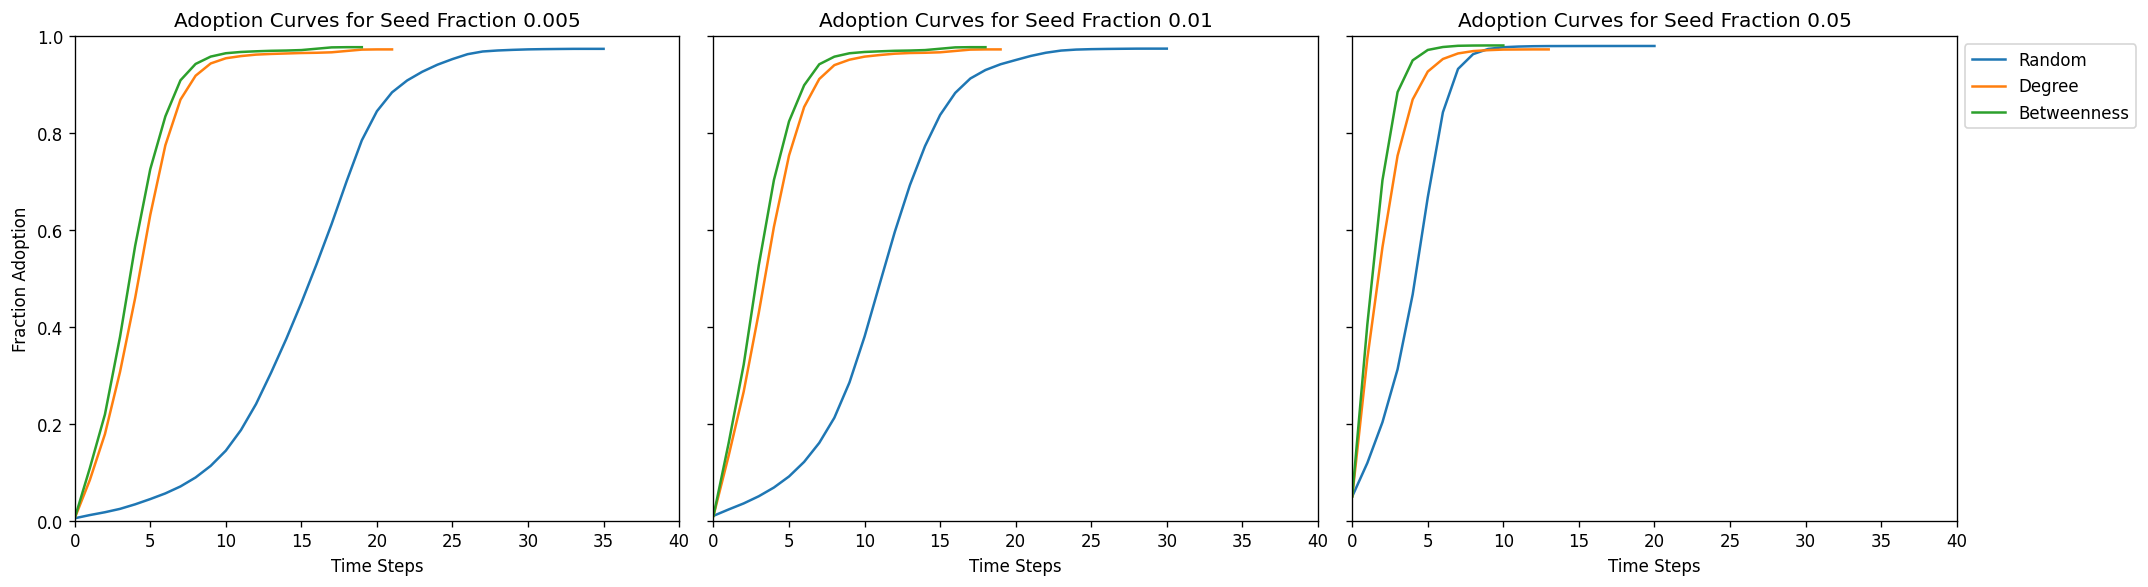

In [59]:
#plot the adoption curves for each strategy and seed fraction
fig, axes = plt.subplots(1, len(seed_fractions), figsize=(18, 5), sharey=True)

for idx, seed_frac_plot in enumerate(seed_fractions):
    subset = results_df[results_df['Seed_Fraction'] == seed_frac_plot]
    ax = axes[idx]

    for strategy_name in strategies:
        strategy_data = subset[subset['Strategy'] == strategy_name]
        #average history over repetitions per strategy
        histories = strategy_data['history'].tolist()

        if len(histories) == 0:
            continue
        max_length = max(len(h) for h in histories)
        #lengths histories the same
        padded_histories = []
        for h in histories:
            if len(h) < max_length:
                pad_val = h[-1]
                extra = np.full((max_length - len(h),), pad_val)
                h = np.concatenate((h, extra))
            padded_histories.append(h)
        mean_history = np.mean(padded_histories, axis=0)
        
        ax.plot(range(len(mean_history)), mean_history, label=strategy_name)

    ax.set_title(f'Adoption Curves for Seed Fraction {seed_frac_plot}')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 40)
    ax.set_xlabel('Time Steps')
axes[0].set_ylabel('Fraction Adoption')
axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("adoption_curves_seed_fraction.png")
plt.show()

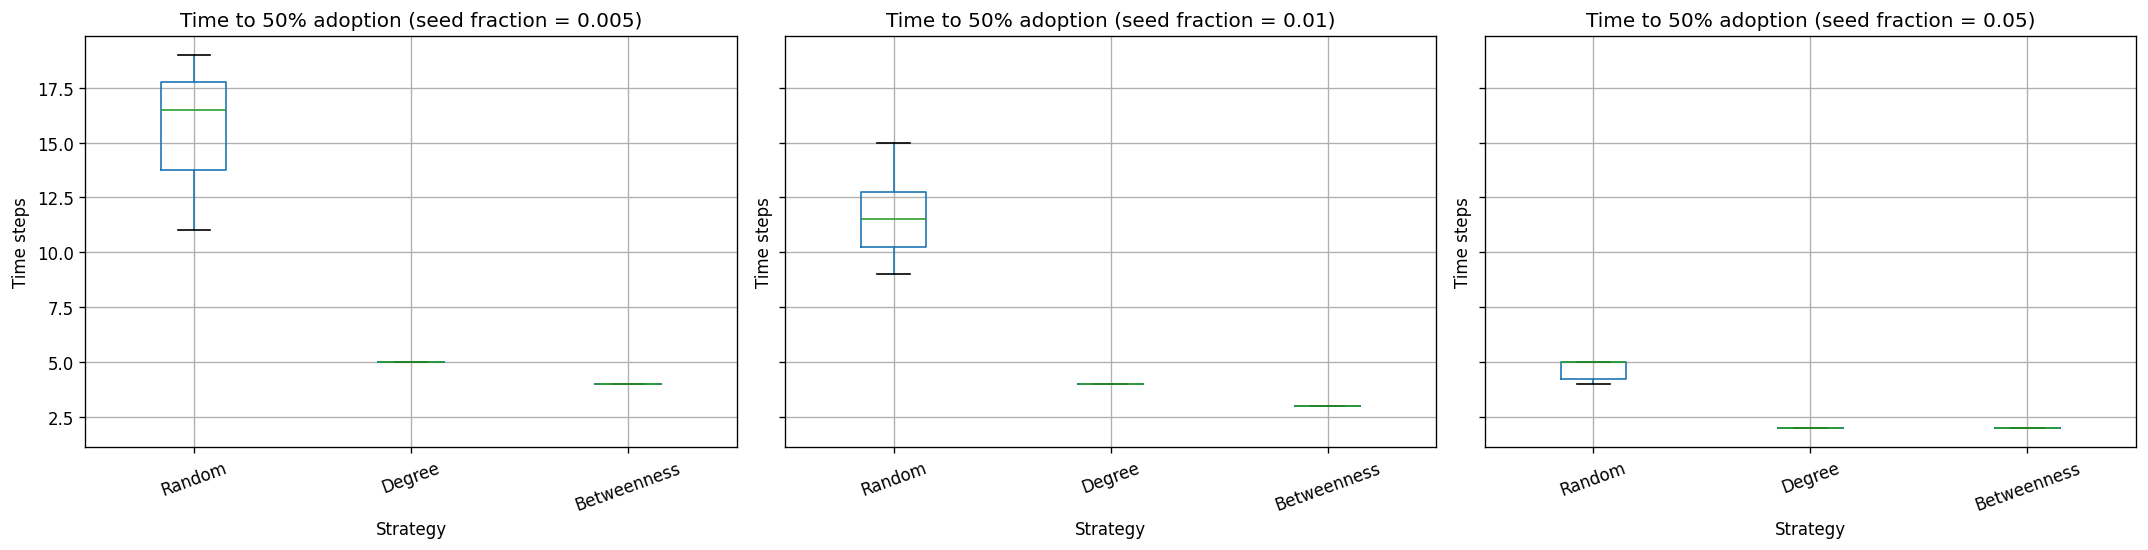

In [63]:
fig, axes = plt.subplots(1, len(seed_fractions), figsize=(18, 5), sharey=True)

for idx, seed_frac_to_plot in enumerate(seed_fractions):

    subset = results_df[results_df["Seed_Fraction"] == seed_frac_to_plot].copy()

    # Force category order
    subset["Strategy"] = pd.Categorical(subset["Strategy"], categories=strategies, ordered=True)

    subset.boxplot(
        column="Time_to_50%_Adoption",
        by="Strategy",
        ax=axes[idx]
    )
    
    axes[idx].set_title(f"Time to 50% adoption (seed fraction = {seed_frac_to_plot})")
    axes[idx].set_ylabel("Time steps")
    axes[idx].set_xlabel("Strategy")
    axes[idx].set_xticklabels(strategies, rotation=20)

plt.tight_layout()
plt.suptitle("")  # remove automatic title
plt.savefig("time_to_50_adoption_seed_fraction.png")
plt.show()


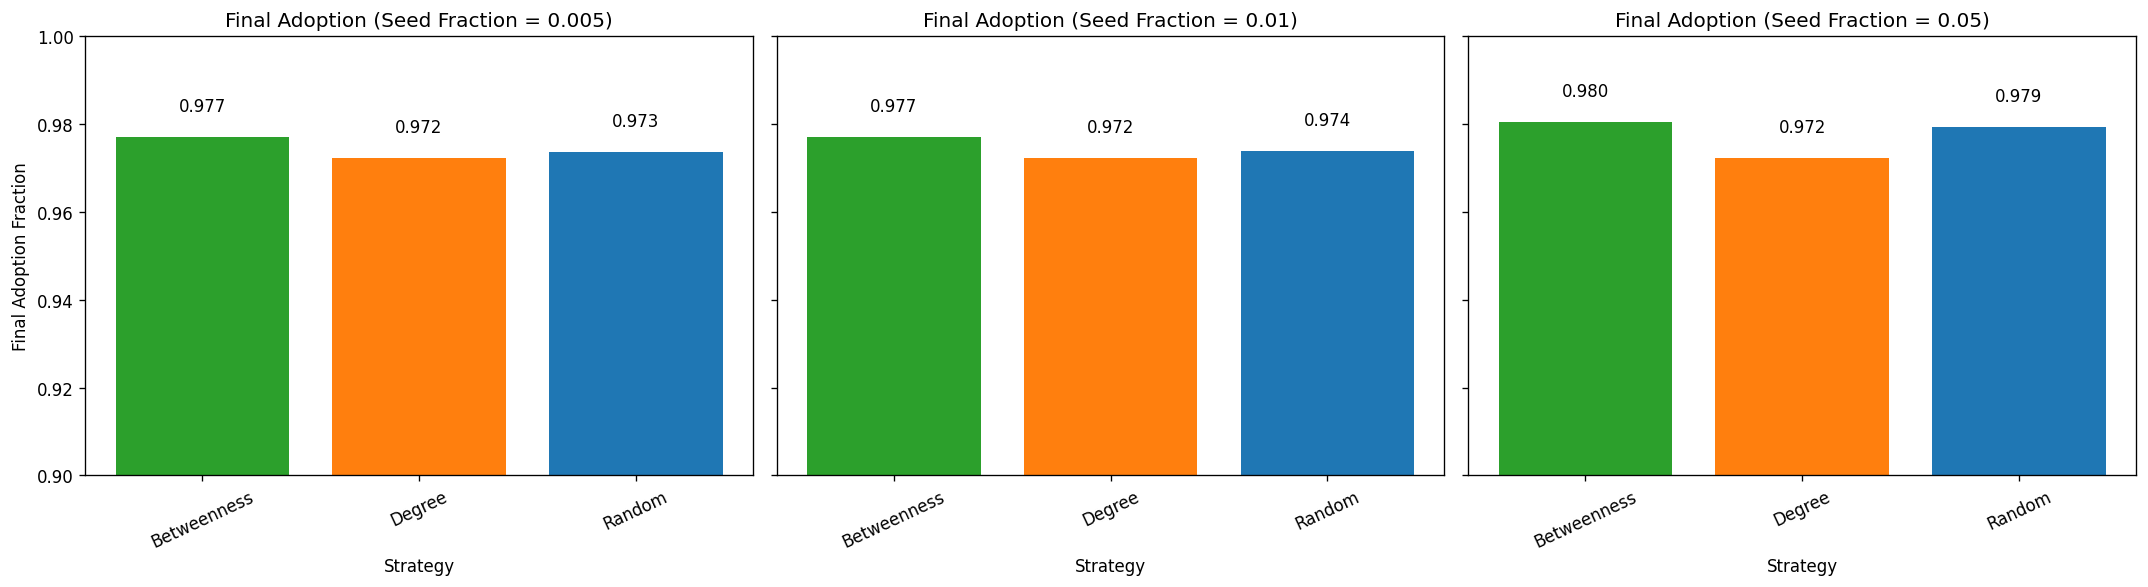

In [ ]:
colors = {
    "Random": "#1f77b4",
    "Degree": "#ff7f0e",
    "Betweenness": "#2ca02c"
}

fig, axes = plt.subplots(1, len(seed_fractions), figsize=(18, 5), sharey=True)

for idx, seed_frac in enumerate(seed_fractions):
    ax = axes[idx]
    subset = results_df[results_df["Seed_Fraction"] == seed_frac]

    mean_final = subset.groupby("Strategy")["Final_Adoption_Fraction"].mean()

    # bar plot with colors
    bar_colors = [colors[strat] for strat in mean_final.index]
    ax.bar(mean_final.index, mean_final.values, color=bar_colors)
    
    for x, y in zip(mean_final.index, mean_final.values):
        ax.text(x, y + 0.005, f"{y:.3f}", ha='center', va='bottom', fontsize=10)


    ax.set_title(f"Final Adoption (Seed Fraction = {seed_frac})")
    ax.set_ylim(0.90, 1)
    ax.set_xlabel("Strategy")
    ax.tick_params(axis='x', rotation=25)
    if idx == 0:
        ax.set_ylabel("Final Adoption Fraction")

plt.tight_layout()
plt.savefig("final_adoption_barplots_colored.png", dpi=300, bbox_inches="tight")
plt.show()
